<a href="https://colab.research.google.com/github/Yadukrishnan1/Customer-Churn-Analysis/blob/main/customer_churn_imb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Data Analysis

The objective of this notebook is to see how much value can be extracted while keeping the imbalance of the datset intact. 

**Loading packages...**




In [69]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for ML prediction and modelling

from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import mean_squared_error, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
from mpl_toolkits import mplot3d
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, RandomizedSearchCV

from xgboost.sklearn import XGBRegressor, XGBClassifier
import xgboost as xgb

from os import path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [70]:
feat_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/features_data.csv")
eq_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Robinhood/equity_value_data.csv")

# **Part 1**: Determine the user classes and find out the percentage of both.

## Exploratory Data Analysis (**EDA**) to determine the users who have churned.

In [71]:
print(eq_df.shape, '\n')
eq_df.head()

(1119158, 3) 



,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [72]:
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119158 entries, 0 to 1119157
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   timestamp     1119158 non-null  object 
 1   close_equity  1119158 non-null  float64
 2   user_id       1119158 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.6+ MB


In [73]:
eq_df.isna().sum()

timestamp       0
close_equity    0
user_id         0
dtype: int64

In [74]:
eq_df.timestamp=pd.to_datetime(eq_df.timestamp, errors='coerce')
eq_df.nunique()

timestamp          255
close_equity    531483
user_id           5584
dtype: int64

# Visualizing Equity Vs Days for a few users

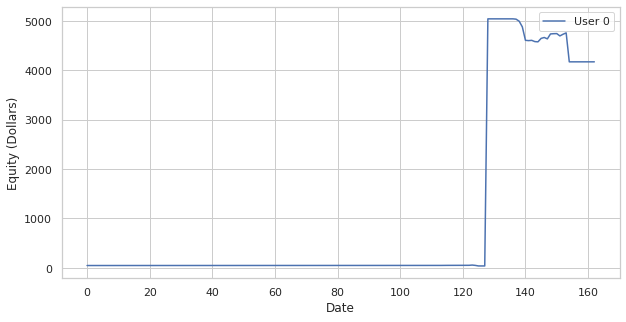

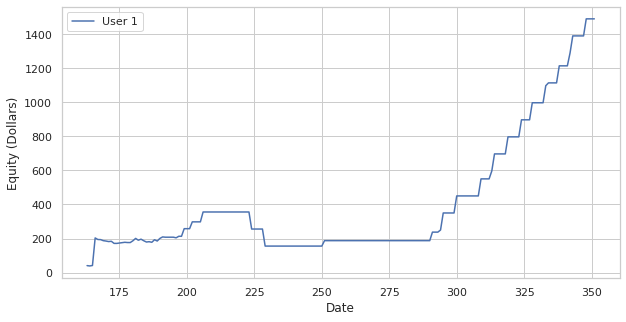

In [75]:
for i in range(2):
    user_eq_df=eq_df[eq_df['user_id']==eq_df[eq_df.columns[2]].unique()[i]]
    
    plt.figure(figsize=(10,5))
    
    ts=user_eq_df["close_equity"]
    time=user_eq_df["timestamp"]
    
    plt.xlabel('Date')
    plt.ylabel('Equity (Dollars)')
    plt.plot(ts, '-', label='User {0}'.format(i));
    plt.legend()
plt.show()

# We determine the two classes of the users - **Churned** or **Not Churned**. 
---
### To determine that, we make use of the condition that if the equity of a user is lower than $10 for 28 consecutive calendar days or longer.

From preliminary analysis of the equity value time-series of each user, we find that the minimum recorded equity value across users is \$10 and the maximum is ~\$4,50,000. This means that whenever the equity vaue goes below $10, those data are excluded from the table. This gives us an oppotunity to simplify the detection of churned users by simply determining the length of the missing time-series data for each user. If the length is over 28+2 (considering the weekend), that user is churned.

---

## The missing days (gap_days) from the dataset can be determined as shown below.

In [76]:
eq_df['gap_days'] = eq_df.timestamp.diff()
eq_df.head(10)

,timestamp,close_equity,user_id,gap_days
0,2016-11-16 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,NaT
1,2016-11-17 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
2,2016-11-18 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
3,2016-11-21 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
4,2016-11-22 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
5,2016-11-23 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
6,2016-11-25 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,2 days
7,2016-11-28 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,3 days
8,2016-11-29 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days
9,2016-11-30 00:00:00+00:00,48.16,bcef4fa9b0bdf22bcf7deae708decf03,1 days


In [77]:
# The number of churned users is obtained by comparing the gap-days with a time-delta of 30 days.

churned_user_count=eq_df[eq_df['gap_days']>=pd.Timedelta("30 days")]['user_id'].nunique()
churned_user_ids=eq_df[eq_df['gap_days']>=pd.Timedelta("30 days")]['user_id'].unique()
print(len(churned_user_ids))

# Total users

total_users=eq_df['user_id'].nunique()
total_user_ids=eq_df['user_id'].unique()
print(len(total_user_ids))


279
5584


# **1. What fraction of the users have churned?**

In [78]:
frac=np.round(100.0*(churned_user_count/total_users), decimals=2)
print('Fraction of churned users is {0}%'.format(frac))

Fraction of churned users is 5.0%


# **Part 2: EDA and ML Model bulding to predict customer churn**




In [262]:
# The feature dataset
feat_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [271]:
feat_df.columns

Index(['risk_tolerance', 'investment_experience', 'liquidity_needs',
       'platform', 'time_spent', 'instrument_type_first_traded',
       'first_deposit_amount', 'time_horizon', 'user_id'],
      dtype='object')

In [80]:
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   user_id                       5584 non-null   object 
dtypes: float64(2), object(7)
memory usage: 392.8+ KB


In [81]:
# Create a datset containing the class label(churn=1, no churn=0) by merging the churned user data with the 'feat_df'

churned_df=pd.DataFrame(churned_user_ids, columns=['user_id'])
churned_df['churn']=1
churned_df.head()

,user_id,churn
0,270cda53a026bcf6c2b98492b23c1b99,1
1,319c069e77187c7e7e7c027eb00fd941,1
2,ec84f134c5b27c4f5702803e98eb3f40,1
3,6dbedf7f2972b4f6ea60a15d48cb292c,1
4,91837d41270b81b267fc205c3e03ee9b,1


In [82]:
churned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  279 non-null    object
 1   churn    279 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


In [287]:
model_df=feat_df.merge(churned_df, how='left', on='user_id').fillna(0)
model_df['churn']=model_df['churn'].astype(int)
model_df=model_df.drop(['user_id'], axis=1)
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,0


In [288]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 0 to 5583
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   risk_tolerance                5584 non-null   object 
 1   investment_experience         5584 non-null   object 
 2   liquidity_needs               5584 non-null   object 
 3   platform                      5584 non-null   object 
 4   time_spent                    5584 non-null   float64
 5   instrument_type_first_traded  5584 non-null   object 
 6   first_deposit_amount          5584 non-null   float64
 7   time_horizon                  5584 non-null   object 
 8   churn                         5584 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 436.2+ KB


In [290]:
cat_df = model_df.select_dtypes(include=['object']).copy()

for i in cat_df.columns:
  print(i, ' : ',cat_df[i].unique())

risk_tolerance  :  ['high_risk_tolerance' 'med_risk_tolerance' 'low_risk_tolerance']
investment_experience  :  ['limited_investment_exp' 'no_investment_exp' 'good_investment_exp'
 'extensive_investment_exp']
liquidity_needs  :  ['very_important_liq_need' 'not_important_liq_need'
 'somewhat_important_liq_need']
platform  :  ['Android' 'iOS' 'both']
instrument_type_first_traded  :  ['stock' 'etp' 'adr' 'wrt' 'mlp' '0' 'lp' 'rlt' 'reit' 'cef' 'tracking']
time_horizon  :  ['med_time_horizon' 'short_time_horizon' 'long_time_horizon']


In [291]:
cat_df = model_df.select_dtypes(include=['object']).copy()

# Creating the categories

risk_categories=['low_risk_tolerance', 'med_risk_tolerance', 'high_risk_tolerance']
exp_categories=['no_investment_exp', 'limited_investment_exp', 'good_investment_exp', 'extensive_investment_exp']
liq_categories=['not_important_liq_need', 'somewhat_important_liq_need', 'very_important_liq_need' ]
platform_categories=['Android', 'iOS', 'both']
instrument_categories= ['stock', 'etp', 'adr', 'wrt', 'mlp', '0', 'lp', 'rlt', 'reit', 'cef', 'tracking']
horizon_categories=['short_time_horizon', 'med_time_horizon', 'long_time_horizon']

# Encoding the columns

enc_make = OrdinalEncoder(categories=[risk_categories, exp_categories, liq_categories, platform_categories, instrument_categories, horizon_categories])

cat_df_transformed = enc_make.fit_transform(cat_df[['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 
                                                    'instrument_type_first_traded','time_horizon']])

for i,j in enumerate(cat_df.columns):
  cat_df[j] = cat_df_transformed.transpose()[i]

# Adding converted labels to df
for i in model_df.columns:
  if i in cat_df.columns:
    model_df[i] = cat_df[i]

for i in cat_df.columns:
  print(i, ' : ',cat_df[i].unique())

risk_tolerance  :  [2. 1. 0.]
investment_experience  :  [1. 0. 2. 3.]
liquidity_needs  :  [2. 0. 1.]
platform  :  [0. 1. 2.]
instrument_type_first_traded  :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
time_horizon  :  [1. 0. 2.]


In [292]:
model_df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
0,2.0,1.0,2.0,0.0,33.129417,0.0,40.0,1.0,0
1,1.0,1.0,2.0,0.0,16.573517,0.0,200.0,0.0,0
2,1.0,1.0,2.0,1.0,10.008367,0.0,25.0,2.0,0
3,1.0,1.0,2.0,0.0,1.031633,0.0,100.0,0.0,0
4,2.0,1.0,2.0,0.0,8.187250,0.0,20.0,2.0,0


In [293]:
model_df.describe()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
count,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000,5584.000000
mean,1.595809,0.908668,1.708990,0.816619,34.509706,0.331483,633.566805,0.820917,0.049964
std,0.571385,0.755589,0.546611,0.575053,155.080551,1.187690,2118.323263,0.896479,0.217890
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,2.848908,0.000000,50.000000,0.000000,0.000000
50%,2.000000,1.000000,2.000000,1.000000,13.474708,0.000000,100.000000,0.000000,0.000000
75%,2.000000,1.000000,2.000000,1.000000,33.823829,0.000000,500.000000,2.000000,0.000000
max,2.000000,3.000000,2.000000,2.000000,8788.329450,10.000000,50000.000000,2.000000,1.000000


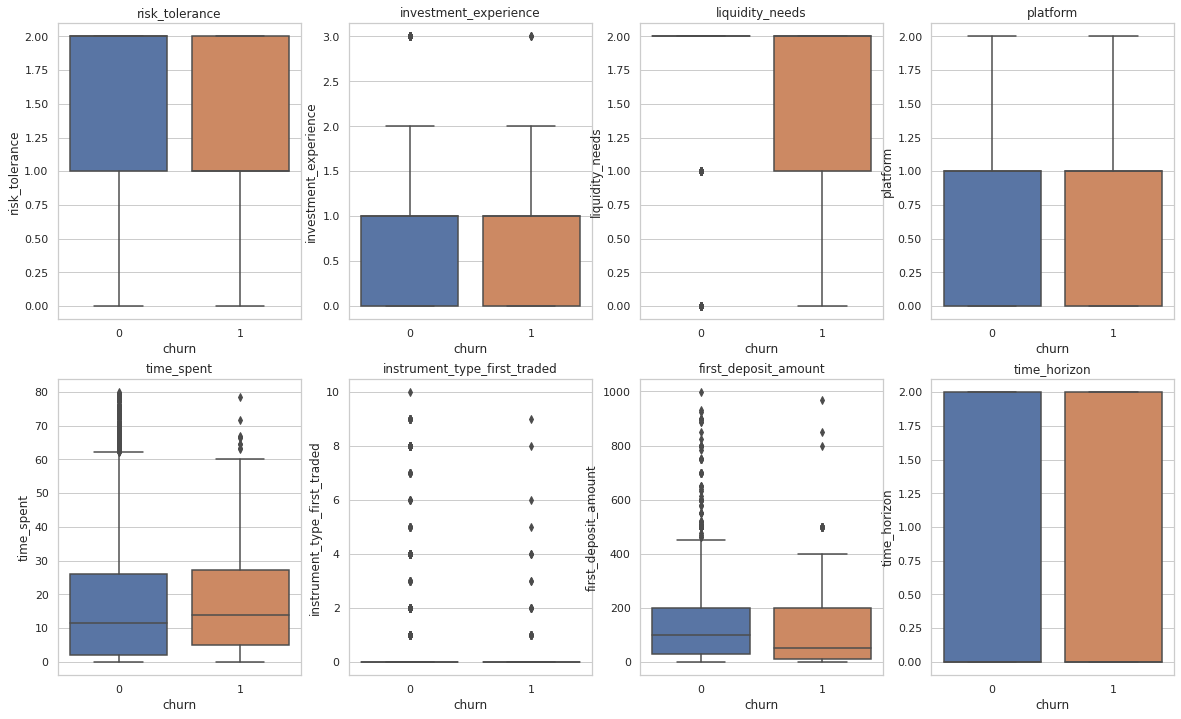

In [294]:
# Outlier detection using seaborn boxplot

model_df=model_df[(model_df['time_spent']<80) & (model_df['first_deposit_amount']<1000)] # Setting some realistic outlier bounds

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 12))

count=0
for i in range(2):
    for j in range(4):
        sns.boxplot(ax=axes[i, j],data=model_df, x='churn', y=model_df.columns[count])
        axes[i,j].set_title(model_df.columns[count])
        count+=1

# **Scaling of Data**

In [295]:
# Scaling of the non-objects

from sklearn.preprocessing import StandardScaler, RobustScaler,MinMaxScaler

mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

scaled_df=model_df.copy()
# We will use Robust scaler because it's ideal if there are outliers
for i in scaled_df.columns[:-1]: # -1 for not to scale the labels
  scaled_df[i] = mm_scaler.fit_transform(model_df[i].values.reshape(-1,1))

scaled_df.describe()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,churn
count,4184.000000,4184.000000,4184.00000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000
mean,0.793380,0.280115,0.85086,0.409656,0.220835,0.034082,0.155298,0.403681,0.055927
std,0.285571,0.246491,0.27591,0.279317,0.236346,0.124560,0.175764,0.450564,0.229809
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.50000,0.000000,0.029613,0.000000,0.025073,0.000000,0.000000
50%,1.000000,0.333333,1.00000,0.500000,0.144586,0.000000,0.100291,0.000000,0.000000
75%,1.000000,0.333333,1.00000,0.500000,0.328299,0.000000,0.200582,1.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


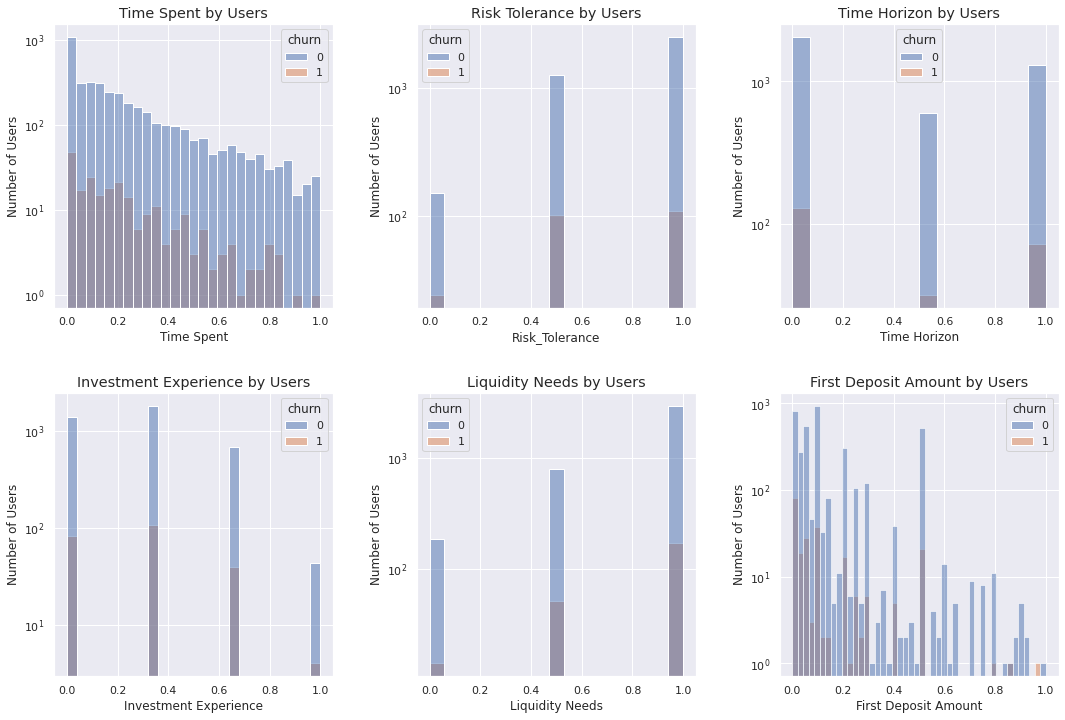

In [322]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.histplot(data=scaled_df, x="time_spent", color='purple', hue='churn', ax=
axes[0,0])
axes[0,0].set_xlabel('Time Spent')
axes[0,0].set_ylabel('Number of Users')
# axes[0,0].legend(loc=7, fontsize='xx-large' )
axes[0,0].set_title('Time Spent by Users', fontsize='large')
axes[0,0].set_yscale('log')

sns.histplot(data=scaled_df, x="risk_tolerance", color='purple', hue='churn', ax=
axes[0,1])
axes[0,1].set_xlabel('Risk_Tolerance')
axes[0,1].set_ylabel('Number of Users')
axes[0,1].set_title('Risk Tolerance by Users', fontsize='large')
axes[0,1].set_yscale('log')

sns.histplot(data=scaled_df, x="investment_experience", color='purple', hue='churn', ax=
axes[1,0])
axes[1,0].set_xlabel('Investment Experience')
axes[1,0].set_ylabel('Number of Users')
axes[1,0].set_title('Investment Experience by Users', fontsize='large')
axes[1,0].set_yscale('log')

sns.histplot(data=scaled_df, x="liquidity_needs", color='purple', hue='churn', ax=
axes[1,1])
axes[1,1].set_xlabel('Liquidity Needs')
axes[1,1].set_ylabel('Number of Users')
axes[1,1].set_title('Liquidity Needs by Users', fontsize='large')
axes[1,1].set_yscale('log')

sns.histplot(data=scaled_df, x="time_horizon", color='purple', hue='churn', ax=
axes[0,2])
axes[0,2].set_xlabel('Time Horizon')
axes[0,2].set_ylabel('Number of Users')
axes[0,2].set_title('Time Horizon by Users', fontsize='large')
axes[0,2].set_yscale('log')

sns.histplot(data=scaled_df, x="first_deposit_amount", color='purple', hue='churn', ax=
axes[1,2])
axes[1,2].set_xlabel('First Deposit Amount')
axes[1,2].set_ylabel('Number of Users')
axes[1,2].set_title('First Deposit Amount by Users', fontsize='large')
axes[1,2].set_yscale('log')

fig.subplots_adjust(wspace=0.3, hspace = 0.3)
plt.show()

Churn events fraction in the data : 5.592734225621415
Non-churn events fraction in the data : 94.40726577437859


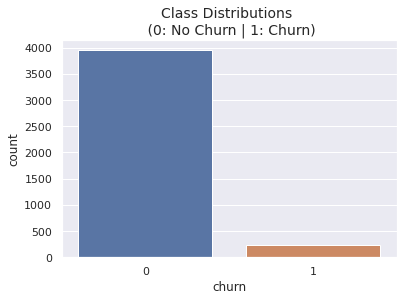

In [306]:
# Class Imbalance

print('Churn events fraction in the data :',len(model_df[model_df['churn']==1])/len(model_df)*100)
print('Non-churn events fraction in the data :',len(model_df[model_df['churn']==0])/len(model_df)*100)

sns.set_theme(style="darkgrid")
g=sns.countplot(data=model_df, x='churn')

plt.title('Class Distributions \n (0: No Churn | 1: Churn)', fontsize=14)
plt.show()

# Class imbalance needs to be taken care before applying model

In [307]:
# Splitting the data

X = scaled_df.drop(columns = ['churn'])
y = scaled_df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X shape -', X_train.shape)
print('y shape -', y_train.shape)

X shape - (2928, 8)
y shape - (2928,)


## Mutual Information to see feature importance

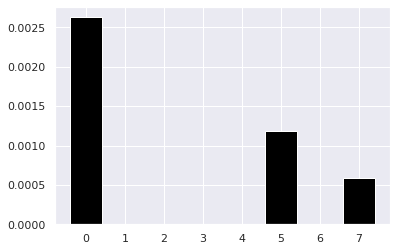

In [325]:
yy=sklearn.feature_selection.mutual_info_classif(X, y, discrete_features='auto', n_neighbors=20, copy=True, random_state=42)
xx=np.arange(len(yy))
plt.bar(xx, yy, color='black')
# plt.yscale('log')
plt.show()

# Feature selection using Chi-square for original, imbalanced data

Feature 0: 4.295383
Feature 1: 0.054584
Feature 2: 0.171005
Feature 3: 0.143262
Feature 4: 12.097400
Feature 5: 0.103881
Feature 6: 1638.272402
Feature 7: 1.845807


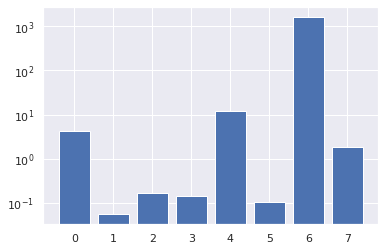

In [326]:
# Chi squared feature selection for categorical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
 
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.yscale('log')
plt.show()

### Random Forest with a single validation data

In [330]:
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train_fs, y_train)

print("Accuracy (in %):", clf.score(X_test_fs, y_test)*100)

# The class determining probability was changed to 0.15 from 0.5 due to imbalance
y_pred = (clf.predict_proba(X_test_fs)[:,1] >= 0.15).astype(bool)
print('F1 score', f1_score(y_test, y_pred))

print('AUC Score = ', roc_auc_score(y_test, clf.predict_proba(X_test_fs)[:, 1]))


Accuracy (in %): 94.5859872611465
F1 score 0.09794628751974724
AUC Score =  0.5561373539314717




## Poor performance from imbalanced data. No surprises here.
Let's check the feature importance for the classifier





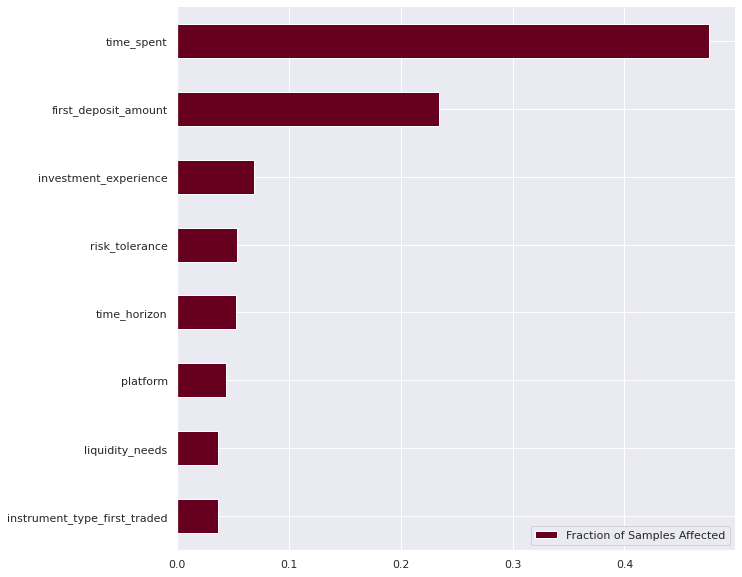

In [332]:
# Plot the feature importance

feat_scores = pd.DataFrame({'Fraction of Samples Affected' : clf.feature_importances_}, index=model_df.columns[:-1])
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,10), colormap='RdGy')
sns.despine()

K-Fold Cross Validation using Decision Tree

In [316]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression

df=model_df

FEATURES=list(df.columns[0:8]) 
TARGET='churn'
f1score=[]
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=None)

for fold, (train_idx, valid_idx) in enumerate(skf.split(df[FEATURES], df[TARGET])):
    X_train, X_valid = df.iloc[train_idx], df.iloc[valid_idx]
    y_train = X_train[TARGET]
    y_valid = X_valid[TARGET]
    X_train = X_train.drop(TARGET, axis=1)
    X_valid = X_valid.drop(TARGET, axis=1)
    
    cbr = tree.DecisionTreeClassifier()

    cbr =  cbr.fit(X_train, y_train)
    y_pred = (cbr.predict_proba(X_valid)[:,1] >= 0.3).astype(bool)
    f1score.append(f1_score(y_valid, y_pred))
    print(f'Fold {fold}: F1: ', f1_score(y_valid, y_pred))

Fold 0: F1:  0.03703703703703704
Fold 1: F1:  0.10062893081761007
Fold 2: F1:  0.11627906976744187


# Hyper-parameter tuning using grid-search CV

In [317]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth": np.arange(2, 4, 6)}
parameters = {'n_estimators': [100, 200], 
              # 'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              # 'max_depth': [2, 3, 5, 10], 
              # 'min_samples_split': [2, 3, 5],
              # 'min_samples_leaf': [1,5,8]
             }

cbr = RandomForestClassifier()
clf = GridSearchCV(cbr, parameters, scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [318]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.322264,0.010943,0.019592,0.001055,entropy,100,"{'criterion': 'entropy', 'n_estimators': 100}",0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,3
1,0.623948,0.012250,0.035859,0.001021,entropy,200,"{'criterion': 'entropy', 'n_estimators': 200}",0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,3
2,0.263478,0.007139,0.019333,0.000649,gini,100,"{'criterion': 'gini', 'n_estimators': 100}",0.060606,0.0,0.0,0.055556,0.0,0.023232,0.028498,1
3,0.518836,0.004065,0.036303,0.000766,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.060606,0.0,0.0,0.000000,0.0,0.012121,0.024242,2


# Boosted Algorithms?

Accuracy (in %): 93.15286624203821
F1 score 0.1435897435897436
(0.11023622047244094, 0.20588235294117646, 0.1435897435897436, None)


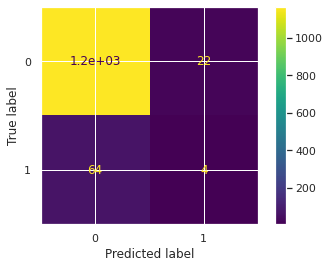

In [340]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=2, random_state=42).fit(X_train, y_train)

print("Accuracy (in %):",clf.score(X_test, y_test)*100)

y_pred = (clf.predict_proba(X_test)[:,1] >= 0.15).astype(bool)
print('F1 score', f1_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)  
print(precision_recall_fscore_support(y_test, y_pred, average='binary'))


plt.show()

In [ ]:
Q4: write code to trim outliers (defined as >/< mean+/-2std) in a df that has ID, 
50 columns of numeric variables (col1, col2, ... col50), 
and one target variable target 1/0

for i in df.columns:
    df=df[df>(df.mean() - 2*df.std()) & df<(df.mean() + 2*df.std())]

for i in df.index:
    df.loc[i]=df.loc[i][df.loc[i]>(df.mean()-2*df.std()) & df.loc[i]<(df.mean()+2*df.std())]